In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x +5 

In [3]:
f(3.0)

20.0

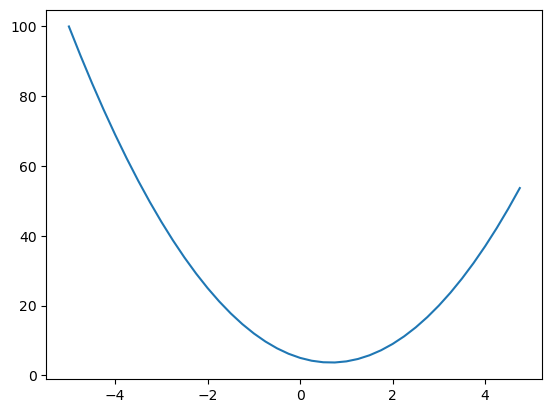

In [4]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.01
(f(2+h) - f(2))/h

8.02999999999976

In [6]:
# a bit more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
h = 0.001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

a += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)


d1 4.0
d2 3.997
slope -3.0000000000001137


In [55]:
class Value:
    def __init__(self, data, _children = (), _op = "", label = ""):
        self.data = data
        self.grad = 0.0 # at initializen, we assume no value impacts the loss
        self._backward = lambda: None #anonyme function die standartmäßig nichts macht 
        self._prev = set(_children) # set for parent nodes
        self._op = _op # marker for operation that led to outcome (together with parent)
        self.label = label
    
    def __repr__(self):
        return f"Value(Data= {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+") # new Value Object with parent nodes saved
        def _backward():
            self.grad += 1 * out.grad #chain rule; +=becaus of backprog bug, when nodes are used multiple times, gradient must accumulate
            other.grad += 1 * out.grad #chain rule
        out._backward = _backward #self._backward wurde im Konsturktor initilasiert mit None -> hier spezifizieren wir die methode für __add__
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad # chain rule: upstream gradient * local gradient
            other.grad += self.data * out.grad
        out._backward = _backward # backprobagation von out-value ist vorher definierte methode mit diesem verhalten
        return out
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        out = Value(self.data ** other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * (self.data**(other -1)) * out.grad
        out._backward = _backward
        return out


    def __truediv__(self, other):# special case von pow (normale divison)
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1) #x transformiere mit tanh -> output davon in t gespeichert
        out = Value(t, (self, ), "tanh") #self-> sozusagen x; rest ist wegen konstruktor; aus einfachem wert t ein objekt machen
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward #out._backward speichert immer die lokale ABleitungsregel (die funktion backward wird als attribut der klasse gespciehrt - wild)
        return out
    
    def exp(self):
        x = self.data
        e = math.exp(x)
        out = Value(e, (self,), "exp")

        def _backward():
            self.grad += out.grad * out.data 
        out._backward = _backward
        return out
    
    def backward(self):
        topo = [] #topologische sortierung: tiefensuche -> knoten in richtiger reihenfolgne in liste einfügen
        visited = set() #knoten nicht mehrmals in die liste einfügen
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child) #add recursivley alle childs -> topo reihenfolge entgegengesetzt dem forward pass
                topo.append(v)
        build_topo(self)
        self.grad = 1.0 #base case
        for node in reversed(topo):
            node._backward()
            

In [9]:
# definiton of values
   
a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
c = Value(10.0, label = "c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label= "f")
L = d * f; L.label = "L"
L

Value(Data= -8.0)

In [10]:
#other example
a = Value(2)
b = Value(3)

a-b
2* a #rmul aufrufen

Value(Data= 4)

In [11]:
#function zur visualsierung
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

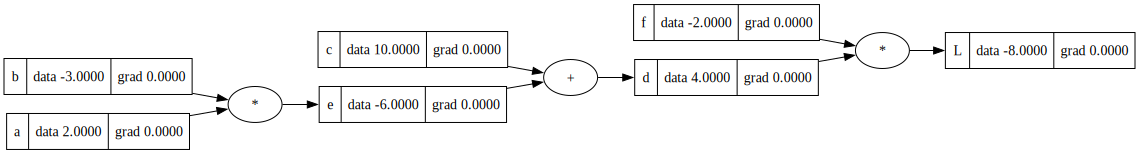

In [12]:
draw_dot(L)
# tldr:
#+routes gradient throug nodes
#* makes the other faktor the lokal gradient 

dL/da = dL/de * de/da

f(x + h) - f(x) / h

= (a + h) * b - (a * b) / h

= (a*b + h*b - a*b) /h
= h*b/h = b

In [13]:
def lol():
    h = 0.01
    
    a = Value(2.0, label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10.0, label = "c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label= "f")
    L = d * f; L.label = "L"
    L1 = L.data

    a = Value(2.0, label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10.0, label = "c")#
    c.data += h
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label= "f")
    L = d * f; L.label = "L"
    L2 = L.data

    # (f(x+h) - f(x)) / h
    print((L2 - L1)/h)


lol()


-1.9999999999999574


In [14]:
L.grad = 1.0

In [15]:
f.data += 0.01 * f.grad
c.data += 0.01 * c.grad
b.data += 0.01 * b.grad
a.data += 0.01 * a.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-32.0


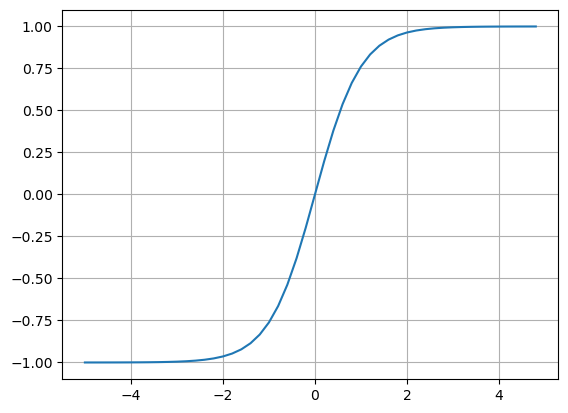

In [16]:
# squashin/activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [17]:
# another example: single layer neuron: 
# inputs: x1, x2

x1= Value(2.0, label= "x1")
x2= Value(0.0, label= "x2")
w1= Value(-3.0, label= "w1")
w2= Value(1.0, label= "w2")
b = Value(6.8813735870195432, label= "b")

x1w1 = x1*w1 
x1w1.label = "x1w1"
x2w2 = x2*w2
x2w2.label = "x2w2"
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label ="x1w1x2w2"

n = x1w1x2w2 + b; n.label="n" #cell body without activation function tanh

o = n.tanh(); o.label = "o"
o.backward()


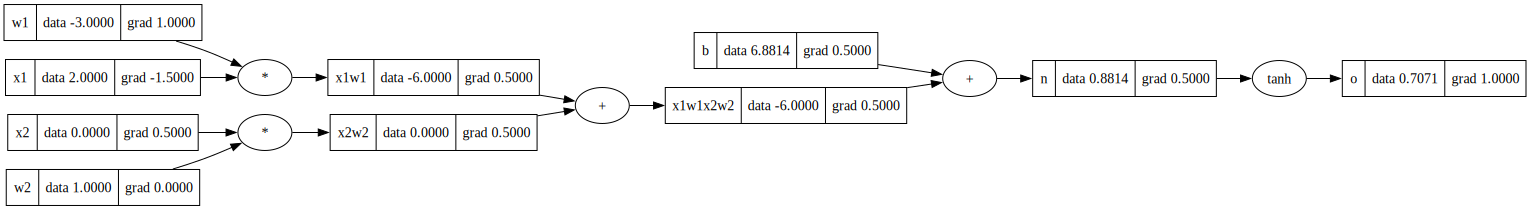

In [18]:
draw_dot(o)

In [19]:
o.backward()

In [20]:
# lokal derivative of tanh: do/dn
# -> do/dn = 1 - tanh(n)**2, where tanh(n) = o
1 - o.data**2

0.4999999999999999

In [21]:
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad #interesting: w2.grad = 0, weil x2 das Produkt eh 0 macht -> w2 hat keinen Einfluss auf Output
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

# backwards exhausting manually -> automatation

In [22]:
o.grad = 1.0 #ersten out.grad -also o.grad- definieren
o._backward() #ruft das backwards attribut von o auf (hier: eine Methode, die in tanh spezifiziert wurde)

In [23]:
n._backward()

In [24]:
b._backward() #passiert nichts, weil standart backward methode mit lambda:none defineirt wrude -> leaf node

In [25]:
x1w1x2w2._backward()

In [26]:
x1w1._backward()
x2w2._backward()

In [27]:
# Master-Anleitung für Reihenfolgen von Backproagation:
# wichtig, damit wenn gradient berechnet wird, alle upstream gradienten schon da sind und man out.grad aufrufen kann
topo = [] #topologische sortierung: tiefensuche -> knoten in richtiger reihenfolgne in liste einfügen
visited = set() #knoten nicht mehrmals in die liste einfügen
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child) #add recursivley alle childs -> topo reihenfolge entgegengesetzt dem forward pass
        topo.append(v)
build_topo(o)
topo

[Value(Data= 6.881373587019543),
 Value(Data= 1.0),
 Value(Data= 0.0),
 Value(Data= 0.0),
 Value(Data= -3.0),
 Value(Data= 2.0),
 Value(Data= -6.0),
 Value(Data= -6.0),
 Value(Data= 0.8813735870195432),
 Value(Data= 0.7071067811865476)]

In [28]:
o.grad = 1.0 #base_case
for node in reversed(topo): #topo umdrehen, eg. bei o starten
    node._backward()

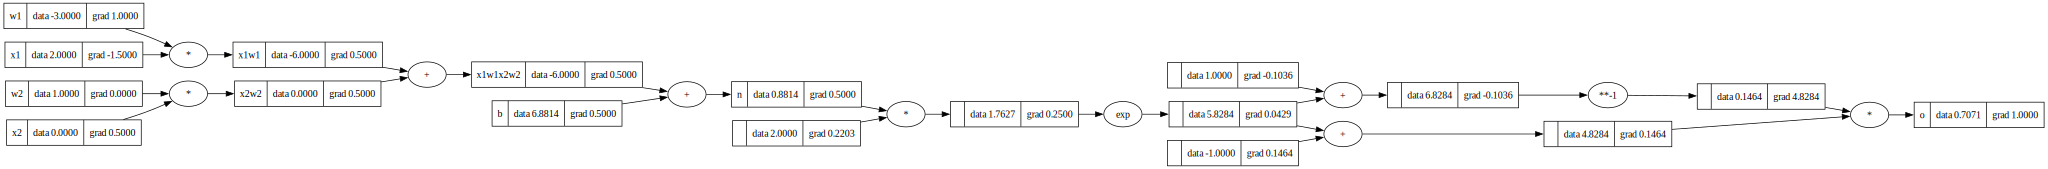

In [29]:
# tanh redefinen

x1= Value(2.0, label= "x1")
x2= Value(0.0, label= "x2")
w1= Value(-3.0, label= "w1")
w2= Value(1.0, label= "w2")
b = Value(6.8813735870195432, label= "b")

x1w1 = x1*w1 
x1w1.label = "x1w1"
x2w2 = x2*w2
x2w2.label = "x2w2"
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label ="x1w1x2w2"

n = x1w1x2w2 + b; n.label="n" #cell body without activation function tanh
#-------

e = (2*n).exp()
o = (e-1) / (e+1); o.label = "o"
o.backward()
draw_dot(o)



In [30]:
# same thing now with pytorch
import torch

x1 = torch.tensor([2.0]).double() # double(): from float32 to float 64
x1.requires_grad = True #by defautl, leave nodes dont have gradient -> efficiency
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())#.data -> same as in manual; .item()-> getting the one element in the tensor as python number
o.backward()

print("------")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())



0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [31]:
o.data.item()

0.7071066904050358

In [32]:
# now we implement a multilayer perceptron
import random

In [113]:
class Neuron:
    def __init__(self, nin): #number of inputs into the neuron
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):#dunder methode für forward pass-> eg object(x): call methode wird ausgeführt
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #aufsummieren, dann addieren
        out = act.tanh()
        return out # forward pass ergebnis zurückgeben
    
    def parameters(self):
        return self.w + [self.b] #self.w ist eine liste, self.b jetzt auch -> liste an paramtern dieses neruons returnen
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)] #jede Layer mit nout neruons -> jedes davon nin
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons] #für jedes neuron forward pass durchführen
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps) #extend erweitert die lsite, append würde verschachtelte listen erstellen
        return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts #erste layer der liste der anderen layers hinzufügen
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] #für alle layers: layer erstellen, jeweilige layer mit anzahl an ausgängen = nin der nächsten schicht

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def paramters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params 

x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(Data= 0.7850941733015592)

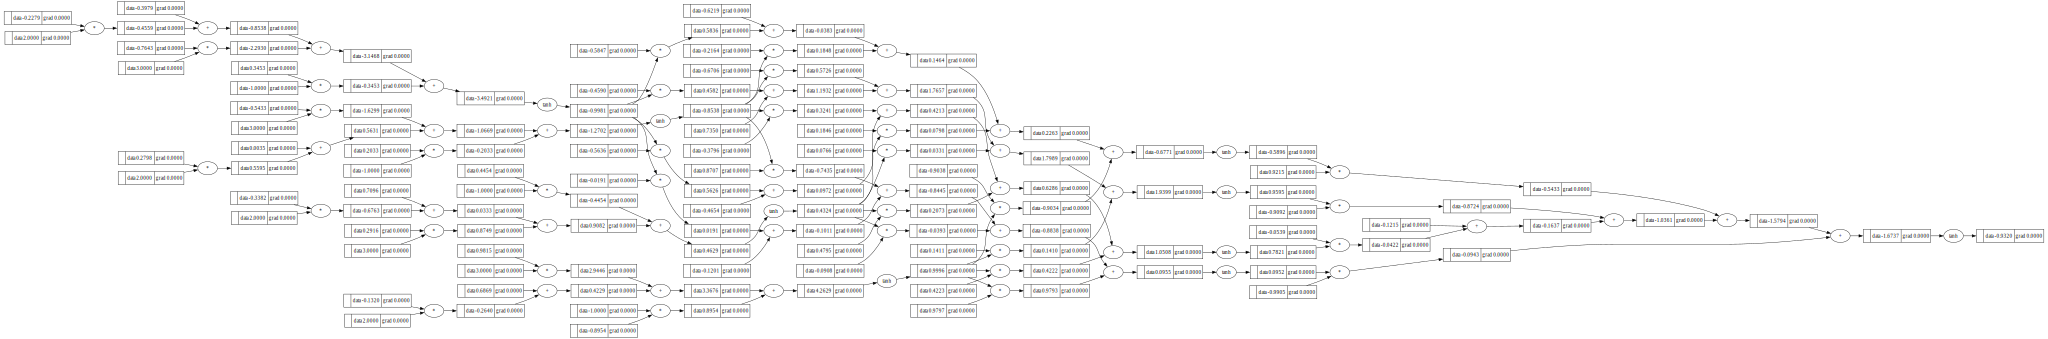

In [42]:
draw_dot(n(x))

In [100]:
#exmaple dataset
xs = [[2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0]

In [61]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
loss

Value(Data= 3.641094891732894)

In [95]:
loss.backward()

In [64]:
len(n.paramters())

41

In [ ]:
n.layers[0].neurons[0].w[0].grad #weight gradient

0.7715687794960383

In [ ]:
n.layers[0].neurons[0].w[0].data #weight value

-0.35222444877829484

In [ ]:
#gradient descent
for p in n.paramters():
    p.data = p.data - 0.01 * p.grad

In [ ]:
n.layers[0].neurons[0].w[0].data #-> negativer geworden, siehe vorheriger weight value

-0.35994013657325524

In [ ]:
#loss erneut berechen
y_pred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred)) #sozusagen forward pass
loss.data


0.0002658410920148983

In [98]:
y_pred

[Value(Data= 0.9883890627092187),
 Value(Data= -0.9991933640080805),
 Value(Data= -0.9960976740369515),
 Value(Data= 0.9892692769256168)]

In [114]:
# now with function
for k in range(20):
    #forward pass -> loss berechnen
    y_pred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
    #loss auf paramter im netz backpropagieren
    for p in n.paramters():
        p.grad = 0.0#die grads werden immer aufaddiert -> vor berechnung neuer grads alte grads resetten
    loss.backward()
    #basierend darauf weight updaten
    for p in n.paramters():
        p.data -= 0.01 * p.grad
    print(k, loss.data)

0 5.8142050249753865
1 5.3998129314856405
2 4.903264968461006
3 4.3453687647541654
4 3.771533572223527
5 3.233617653365017
6 2.763758444926456
7 2.3677877379536016
8 2.0373375176491884
9 1.761331448455305
10 1.5302558637411734
11 1.3365190826679656
12 1.1739293562791477
13 1.0372877604568191
14 0.9221833766059857
15 0.824891114546183
16 0.7422983978903803
17 0.6718323895935417
18 0.6113842172989754
19 0.5592346068136487


In [115]:
y_pred

[Value(Data= 0.765013875540265),
 Value(Data= -0.7033142040546845),
 Value(Data= -0.4526980782664112),
 Value(Data= 0.658746028483099)]